## DISCLAIMER

This is implementation from pyTorch tutorials - https://pytorch.org/tutorials/intermediate/reinforcement_ppo.html

They use some weird convention of naming value network as critic network and policy network as actor network. This is not only the matter of this notebook or their tutorial but also the parameters withing torchrl library

There is also tutorial using mlagents library - https://github.com/Unity-Technologies/ml-agents/blob/develop/colab/Colab_UnityEnvironment_2_Train.ipynb

## Importing Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
from torch import multiprocessing
from torch import nn
from tensordict.nn import TensorDictModule

from collections import defaultdict

In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
from torch import multiprocessing

In [3]:
is_fork = multiprocessing.get_start_method() == "fork"

device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)

## Hyperparameters

In [4]:
num_cells = 256  # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0

### Data Collection

In [5]:
# buffer_size = 10000
# batch_size = 1000 # Number of frames per batch
# For a complete training, bring the number of frames up to 1M
total_frames = 100_000 # total size of frames to train on
max_steps = 500

### PPO parameters

In [6]:
buffer_size = 2560
batch_size = 1024
sub_batch_size = 512

num_epochs = 3  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95

# Calculating PPO loss
critic_coef = 0.5
entropy_eps = 0.005
# entropy_eps = 0

### Environment parameters

In [7]:
time_scale = 2

## Environment Preparation

#### Load unity environment using `mlagents_envs`

In [8]:
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
from mlagents_envs.environment import UnityEnvironment

channel = EngineConfigurationChannel()
env_path = "C:/Users/Pawel/Documents/Unity_Project/warehouse-bot-training/environment_builds/test_env_simplified/Warehouse_Bot.exe"

from torchrl.envs import UnityMLAgentsEnv

unity_env = UnityEnvironment(
  file_name=env_path,
  side_channels=[channel],
  # additional_args=["-batchmode", "-nographics"]
)
channel.set_configuration_parameters(time_scale=time_scale)

c:\Users\Pawel\anaconda3\envs\mlagents\lib\site-packages\mlagents_envs\environment.py:94: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  unity_communicator_version = StrictVersion(unity_com_ver)


#### Transform environment to Gym format from `mlagents_envs` package

In [9]:
from mlagents_envs.envs.unity_gym_env import UnityToGymWrapper
# gym_env = UnityToGymWrapper(unity_env, uint8_visual=False, flatten_branched=False, allow_multiple_obs=True)
gym_env = UnityToGymWrapper(unity_env, allow_multiple_obs=True)

#### Transform environment to pure `gym` package format from `mlagents_envs` gym format

In [10]:
import gym
import numpy as np
from mlagents_envs.base_env import TerminalSteps

class UnityGymTorchWrapper(gym.Env):
    """
    Custom wrapper for UnityToGymWrapper to make it compatible with TorchRL's GymWrapper.
    """

    def __init__(self, unity_gym_env):
        """
        Takes unity_gym_env - environment from "mlagents_envs" package
        """ 
        super().__init__()
        
        self.unity_gym_env = unity_gym_env
        self.observation_space = unity_gym_env.observation_space
        self.action_space = unity_gym_env.action_space
        
    def reset(self):
        observation = self.unity_gym_env.reset()
        
        if isinstance(observation, list):  
            observation = np.concatenate(observation, axis=-1)
        
        return {"observation": observation}, {}  # TorchRL expects a dictionary

    def step(self, action):
        observation, reward, terminated, info = self.unity_gym_env.step(action)
        
        # Truncated should be true only when episode ended prematurely - didn't reach max step
        truncated = False
        decision_steps = info['step'] # steps (with s) because by can describe multiple agents
        
        # Check if episode ended
        if isinstance(decision_steps, TerminalSteps):
            # True when max steps reached - oposite of truncated
            truncated = not decision_steps.interrupted[0]
            # print(f"Did end prematurely? {truncated}")
        
        if isinstance(observation, list):  
            observation = np.concatenate(observation, axis=-1)
        
        return {"observation": observation}, reward, terminated, truncated, info

    def render(self, mode="human"):
        return self.unity_gym_env.render(mode=mode)

    def close(self):
        self.unity_gym_env.close()

In [11]:
custom_env = UnityGymTorchWrapper(gym_env)

#### Transform again to gym format but from `torchrl` package

In [12]:
from torchrl.envs import GymWrapper
torchrl_gym_env = GymWrapper(custom_env)

In [13]:
_ = torchrl_gym_env.rollout(1000)

#### Transforming environment

In [14]:

from torchrl.envs import Compose, DoubleToFloat, ObservationNorm, StepCounter, TransformedEnv

env = TransformedEnv(
    torchrl_gym_env,
    Compose(
        # ObservationNorm(in_keys=["observation"]), # normalize observations
        DoubleToFloat(),
        StepCounter(),
    ),
)

# env.transform[0].init_stats(num_iter=500, reduce_dim=0, cat_dim=0)

## Environment Testing

In [15]:
# print("normalization constant shape:", env.transform[0].loc.shape)

In [16]:
# print("--- observation_spec:", env.observation_spec)
# print("--- reward_spec:", env.reward_spec)
# print("--- input_spec:", env.input_spec)
# print("--- action_spec (as defined by input_spec):", env.action_spec)

In [17]:
from torchrl.envs.utils import check_env_specs
check_env_specs(env)

2025-02-16 18:40:04,346 [torchrl][INFO] check_env_specs succeeded!


In [18]:
rollout = env.rollout(100)
# print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

Shape of the rollout TensorDict: torch.Size([100])


## Policy Network

In [19]:
class Policy_Network(nn.Module):
    def __init__(self, num_cells) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.LazyLinear(num_cells, device=device),
            nn.ReLU(),
            nn.LazyLinear(num_cells, device=device),
            nn.ReLU(),
            nn.LazyLinear(env.action_spec.shape[-1], device=device),
        )
        
    def forward(self, inputs):        
        result = self.main(inputs)
        return result

In [20]:
policy_net = Policy_Network(num_cells).to(device)

policy_module = TensorDictModule(
    policy_net, in_keys=["observation"], out_keys=["logits"]
)

from torchrl.modules import ProbabilisticActor, OneHotCategorical

policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["logits"],
    distribution_class=OneHotCategorical,
    distribution_kwargs={},
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
).to(device)

c:\Users\Pawel\anaconda3\envs\mlagents\lib\site-packages\tensordict\nn\probabilistic.py:460: DeprecationWarning: You are querying the log-probability key of a SafeProbabilisticModule where the composite_lp_aggregate has not been set and the log-prob key has not been chosen. Currently, it is assumed that composite_lp_aggregate() will return True: the log-probs will be aggregated in a sample_log_prob entry. From v0.9, this behaviour will be changed and individual log-probs will be written in `('path', 'to', 'leaf', '<sample_name>_log_prob')`. To prepare for this change, call `set_composite_lp_aggregate(mode: bool).set()` at the beginning of your script (or set the COMPOSITE_LP_AGGREGATE env variable). Use mode=True to keep the current behaviour, and mode=False to use per-leaf log-probs.
  warnings.warn(


## Value Network

In [21]:
class Value_Network(nn.Module):
    def __init__(self, num_cells) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.LazyLinear(num_cells, device=device),
            nn.ReLU(),
            nn.LazyLinear(num_cells, device=device),
            nn.ReLU(),
            nn.LazyLinear(1, device=device),
            nn.Flatten()
        )
        
    def forward(self, inputs):
        result = self.main(inputs)
        return result

In [22]:
from torchrl.modules import ValueOperator

value_net = Value_Network(128).to(device)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
).to(device)

## Tesitng Policy and Value Modules

In [23]:
print("Running policy:", policy_module(env.reset().to(device)))
print("Running value:", value_module(env.reset().to(device)))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1, 3]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        logits: Tensor(shape=torch.Size([1, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        observation: Tensor(shape=torch.Size([1, 52]), device=cpu, dtype=torch.float32, is_shared=False),
        sample_log_prob: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        step_count: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
Running value: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu

## Data Collector

In [24]:
from torchrl.collectors import SyncDataCollector

collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=batch_size,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
    reset_when_done=True, # ??? VERIFY
    # reset_at_each_iter=True
    # reset_at_each_iter=True, # ??? VERIFY - Should be false (default)
)

## Replay Buffer

In [25]:
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement

replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=buffer_size),
    sampler=SamplerWithoutReplacement(),
)

## Loss Function

In [26]:
from torchrl.objectives.value import GAE

# GAE - Generalized Advantage Estimation
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)


from torchrl.objectives import ClipPPOLoss
loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    
    critic_coef=critic_coef,
)

optimizer = torch.optim.Adam(loss_module.parameters(), lr)

from torch.optim.lr_scheduler import LambdaLR
lr_scheduler = LambdaLR(optimizer, lambda epoch: 1 - batch_size / total_frames)

## Trainign Loop

In [27]:
print("Policy Device:", next(policy_module.parameters()).device)
print("Environment Device:", env.device)

Policy Device: cpu
Environment Device: cpu


In [28]:
from torchrl.envs.utils import LazyStackedTensorDict
import pandas as pd

from tqdm import tqdm

logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.

    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.

        # Compute advantage
        advantage_module(tensordict_data)
        
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(batch_size // sub_batch_size):
          
            subdata = replay_buffer.sample(sub_batch_size)
            
            loss_dict = loss_module(subdata.to(device))
            
            if 'loss_entropy' in loss_dict:
                loss_value = (
                    loss_dict["loss_objective"]
                    + loss_dict["loss_critic"]
                    + loss_dict["loss_entropy"]
                )
            else:
                loss_value = (
                    loss_dict["loss_objective"]
                    + loss_dict["loss_critic"]
                )
            
            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            
            optimizer.step()
            optimizer.zero_grad()

    if i % 1 == 0:
        # Loggs ---
        
        # Convert to CPU & NumPy for easier aggregation
        rewards = tensordict_data["next", "reward"].cpu().numpy().flatten()
        done_flags = tensordict_data["done"].cpu().numpy().flatten()
        traj_ids = tensordict_data["collector", "traj_ids"].cpu().numpy().flatten()

        # Create a DataFrame for easier aggregation
        df = pd.DataFrame({"traj_id": traj_ids, "reward": rewards, "done": done_flags})

        # Sum rewards for each unique trajectory ID
        episode_rewards = df.groupby("traj_id")["reward"].sum().to_numpy()
    
        logs["reward"].append(tensordict_data["next", "reward"].mean().item())
        logs["reward_episodes"].append(episode_rewards.mean())
        
        reward_str = (
            f"avg reward={logs['reward'][-1]} (init={logs['reward'][0]}) episode reward={logs['reward_episodes'][-1]} (init={logs['reward_episodes'][0]})"
        )
        
        logs["step_count"].append(tensordict_data["step_count"].max().item())
        stepcount_str = f"step count (max): {logs['step_count'][-1]}"
        
        logs["lr"].append(optimizer.param_groups[0]["lr"])
        lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
        
    pbar.set_description(", ".join([reward_str, stepcount_str, lr_str]))
    pbar.update(tensordict_data.numel())
    
    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    lr_scheduler.step()

  0%|          | 0/100000 [00:00<?, ?it/s]c:\Users\Pawel\anaconda3\envs\mlagents\lib\site-packages\tensordict\nn\probabilistic.py:460: DeprecationWarning: You are querying the log-probability key of a SafeProbabilisticModule where the composite_lp_aggregate has not been set and the log-prob key has not been chosen. Currently, it is assumed that composite_lp_aggregate() will return True: the log-probs will be aggregated in a sample_log_prob entry. From v0.9, this behaviour will be changed and individual log-probs will be written in `('path', 'to', 'leaf', '<sample_name>_log_prob')`. To prepare for this change, call `set_composite_lp_aggregate(mode: bool).set()` at the beginning of your script (or set the COMPOSITE_LP_AGGREGATE env variable). Use mode=True to keep the current behaviour, and mode=False to use per-leaf log-probs.
  warnings.warn(
avg reward=-0.49296870827674866 (init=-0.5906249284744263) episode reward=-126.20000457763672 (init=-120.95999908447266), step count (max): 328, 

In [29]:
env.action_spec.space

CategoricalBox(n=3)

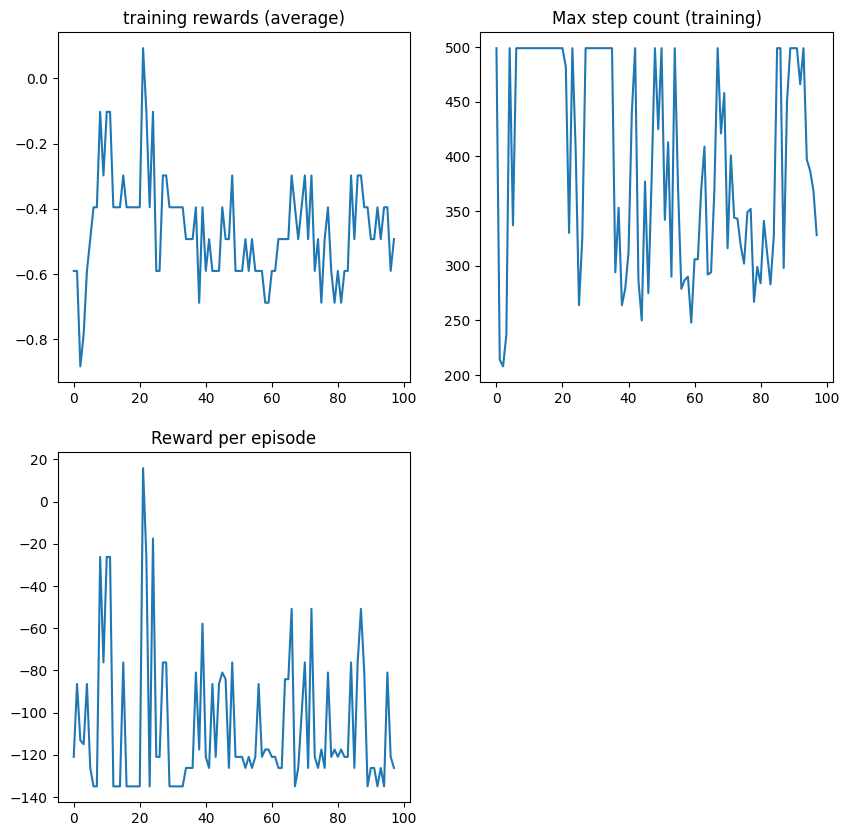

avg reward=-0.49296870827674866 (init=-0.5906249284744263) episode reward=-126.20000457763672 (init=-120.95999908447266), step count (max): 328, lr policy:  0.0003: : 100352it [17:00, 98.78it/s]

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")

plt.subplot(2, 2, 3)
plt.plot(logs["reward_episodes"])
plt.title("Reward per episode")
plt.show()